In [1]:
import pandas as pd 
import numpy as np 

# Train test spliting 
from sklearn.model_selection import train_test_split

# Linear models 
from sklearn.linear_model import LinearRegression 

# Multilabel binarizer 
from sklearn.preprocessing import MultiLabelBinarizer

# Iteration tracking 
from tqdm import tqdm 

# Raw data reading 

In [2]:
d = pd.read_excel('input/residents1.xlsx') 

KeyboardInterrupt: 

In [3]:
d.to_parquet('input/residents1.parquet', index=False)

In [2]:
d = pd.read_parquet('input/residents1.parquet')

In [4]:
# Aggregating number of building permits to each eldership. 
d['LEIDIMO_DATA'] = pd.to_datetime(d['LEIDIMO_DATA'], errors='coerce')


df = d.dropna(subset=['LEIDIMO_DATA'])

df['Year_Month'] = df['LEIDIMO_DATA'].dt.to_period('M')

result = df.groupby(['Year_Month', 'USER_eldership']).size().reset_index(name='Permit_Count')

result['Year_Month'] = result['Year_Month'].astype(str)

print(result)

     Year_Month  USER_eldership  Permit_Count
0       2012-09  Naujoji Vilnia             3
1       2012-09         Verkiai             7
2       2012-10      Antakalnis             4
3       2012-10  Naujoji Vilnia             3
4       2012-10         Pilaitė             4
...         ...             ...           ...
1186    2024-01         Verkiai            35
1187    2024-03      Antakalnis             2
1188    2024-03       Šnipiškės             2
1189    2024-04     Senamiestis             2
1190    2024-06      Antakalnis             8

[1191 rows x 3 columns]


C:\Users\austeja.burmonaite\AppData\Local\Temp\ipykernel_11780\3639914784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Month'] = df['LEIDIMO_DATA'].dt.to_period('M')


In [8]:
d.head()

,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,Join_Count_12,TARGET_FID_12,JOIN_FID,Match_addr,USER_gender,USER_dateOfBirth,...,FZ,Water,Wetlands,Tree_Canopy,Meadow,Barren,Structures,Imperv_Surf,Imperv_Roads,Imperv_all
0,1,1.0,1,1.0,0.0,1,-1,"76 Justiniškių g., Justiniškės, Vilnius",Vyras,9/12/1916,...,None,73104.0,0.0,212347240.0,489134026.0,43177400.0,104276772.0,99258575.0,50791254.0,20.0
1,1,2.0,1,2.0,0.0,2,-1,"9 Kazliškių g., Žirmūnai, Vilnius",Vyras,6/18/1921,...,IUGZ,41243.0,0.0,257264214.0,243567543.0,0.0,234433441.0,244470844.0,15856676.0,48.0
2,1,3.0,1,3.0,0.0,3,-1,"71 Žirmūnų g., Žirmūnai, Vilnius",Vyras,8/15/1921,...,IUGZ,26831.0,0.0,285302639.0,226145611.0,0.0,218855247.0,233175354.0,34076927.0,45.0
3,1,4.0,1,4.0,0.0,4,-1,"27 Elnių g., Žvėrynas, Vilnius",Vyras,9/10/1921,...,MDCZ,0.0,0.0,304075489.0,239358025.0,0.0,259718227.0,132443409.0,54042506.0,39.0
4,1,5.0,1,5.0,0.0,5,-1,"4 Žirmūnų g., Žirmūnai, Vilnius",Vyras,2/20/1922,...,IUGZ,0.0,0.0,237733364.0,214005604.0,0.0,242857685.0,273723965.0,24497526.0,52.0


In [ ]:
type(d['USER_registrationDate'])

In [3]:
def convert_to_timestamp(x):
   try: 
      return pd.to_datetime(x)
   except: 
      return None 
 

d["USER_registrationDate"] = [convert_to_timestamp(x) for x in d["USER_registrationDate"]]
d['USER_dateOfBirth'] = [convert_to_timestamp(x) for x in d["USER_dateOfBirth"]]

d.dropna(subset=['USER_dateOfBirth', 'USER_registrationDate'], inplace=True) 
d['ageAtRegistration'] = (d['USER_registrationDate'] - d['USER_dateOfBirth']).dt.days // 365

# Binning the ages to bins of 10 years
d['age_bin'] = pd.cut(d['ageAtRegistration'], bins=np.arange(-1, 120, 10))
d['age_bin'] = d['age_bin'].astype(str)

# Converting registrationDate to YYYY-MM format 
d['timestep'] = d['USER_registrationDate'].dt.to_period('M')

# Converting the time steps to integers 
min_timestep = d['timestep'].min()
max_timestep = d['timestep'].max() 
timestep_sequence = pd.period_range(min_timestep, max_timestep, freq='M') 
timestep_df = pd.DataFrame({'timestep': timestep_sequence, 'timestep_int': np.arange(len(timestep_sequence))}) 
d = pd.merge(d, timestep_df, on='timestep', how='left') 

# Creating modeling data 

In [4]:
# Defining a list of dummy features 
dummy_features = ['age_bin', 'USER_gender', 'USER_eldership','LEIDIMO_DATA']

# Dropping the missing rows in the dummy features
d = d.dropna(subset=dummy_features)

dd = d[['timestep_int'] + dummy_features].copy() 
dd = dd.groupby(['timestep_int'] + dummy_features).size().reset_index(name='count')

# Creating the dummy data 
dd = pd.get_dummies(dd, columns=dummy_features)

# Spliting to train and test frames 
train, test = train_test_split(dd, test_size=0.2, random_state=42) 

# Creating the x, y pairs
X_train = train.drop('count', axis=1)
y_train = train['count']

X_test = test.drop('count', axis=1)
y_test = test['count']

print(train.shape, test.shape)

(40224, 4090) (10057, 4090)


## Linear regression model 

In [5]:
model = LinearRegression()
model.fit(X_train, y_train) 

# Saving the features 
features = X_train.columns

# Predicting 
yhat = model.predict(X_train)

# Calculating the metrics 
errors = y_train - yhat 
abs_errors = np.abs(errors)
sq_errors = errors ** 2 
print('Mean absolute error:', abs_errors.mean())
print('Mean squared error:', sq_errors.mean()) 

# Extracting the coefficients 
coefs = pd.Series(model.coef_, index=features) 
coefs = coefs.sort_values(ascending=False) 

# Adding the intercept
coefs['intercept'] = model.intercept_ 

Mean absolute error: 0.3441802062799557
Mean squared error: 1.4609213805507897


In [6]:
# Predicting on the test set 
yhat_test = model.predict(X_test) 

# Calculating the metrics
errors_test = y_test - yhat_test
abs_errors_test = np.abs(errors_test)
sq_errors_test = errors_test ** 2
print('Mean absolute error (test):', abs_errors_test.mean())
print('Mean squared error (test):', sq_errors_test.mean())

Mean absolute error (test): 7007559.676206326
Mean squared error (test): 8.275894926811507e+16


# Forecasting 

The forecasting strategy is to create dummy presentations for each gender, age group and municipality and to create an integer timestep into the future. 

In [7]:
# Getting maximum date in the dataset 
max_date = d['USER_registrationDate'].max() 

# Defining the number of maximum months to forecast ahead 
n_months = 24 

# Creating the future time steps 
future_timesteps = pd.period_range(max_date, periods=n_months, freq='M') 
future_timesteps_df = pd.DataFrame({'timestep': future_timesteps, 'timestep_int': np.arange(len(timestep_sequence), len(timestep_sequence) + n_months)})

# Extracting the unique timesteps 
unique_timesteps = future_timesteps_df['timestep_int'].unique()

In [8]:
# For each unique dummy feature, getting all the unique values 
dummy_features_values = {}
for dummy_feature in dummy_features:
    dummy_features_values[dummy_feature] = d[dummy_feature].unique().tolist()

# Creating the meshed grid of all possible combinations of the dummy features
from itertools import product
meshed_grid = list(product(*dummy_features_values.values()))

print('Number of possible combinations:', len(meshed_grid))

Number of possible combinations: 1703100


In [13]:
# Iterating over each timestep to the future and predicing the counts
future_predictions = []
for timestep_int in tqdm(unique_timesteps):
    # Iterating over all the tuples 
    for obs in meshed_grid:
        # Creating the prediction frame
        prediction_df = pd.DataFrame({'timestep_int': [timestep_int], **dict(zip(dummy_features, obs))})

        # Creating the dummy data
        prediction_df = pd.get_dummies(prediction_df, columns=dummy_features)

        # Ensuring the columns are the same as the training columns
        missing_columns = set(features) - set(prediction_df.columns)
        for column in missing_columns:
            prediction_df[column] = 0

        # Sorting the columns
        prediction_df = prediction_df[features]

        # Predicting
        prediction = model.predict(prediction_df) 

        # Appending the prediction
        future_predictions.append({'timestep_int': timestep_int, **dict(zip(dummy_features, obs)), 'count': prediction[0]})

100%|██████████| 24/24 [02:22<00:00,  5.95s/it]


In [14]:
# Creating a dataframe out of the predictions 
future_predictions_df = pd.DataFrame(future_predictions)

# Giving the timesteps the correct format
future_predictions_df = pd.merge(future_predictions_df, future_timesteps_df, on='timestep_int', how='left') 

c:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


USER_eldership
Antakalnis        AxesSubplot(0.125,0.11;0.775x0.77)
Fabijoniškės      AxesSubplot(0.125,0.11;0.775x0.77)
Grigiškės         AxesSubplot(0.125,0.11;0.775x0.77)
Justiniškės       AxesSubplot(0.125,0.11;0.775x0.77)
Karoliniškės      AxesSubplot(0.125,0.11;0.775x0.77)
Lazdynai          AxesSubplot(0.125,0.11;0.775x0.77)
Naujamiestis      AxesSubplot(0.125,0.11;0.775x0.77)
Naujininkai       AxesSubplot(0.125,0.11;0.775x0.77)
Naujoji Vilnia    AxesSubplot(0.125,0.11;0.775x0.77)
Paneriai          AxesSubplot(0.125,0.11;0.775x0.77)
Pašilaičiai       AxesSubplot(0.125,0.11;0.775x0.77)
Pilaitė           AxesSubplot(0.125,0.11;0.775x0.77)
Rasos             AxesSubplot(0.125,0.11;0.775x0.77)
Senamiestis       AxesSubplot(0.125,0.11;0.775x0.77)
Verkiai           AxesSubplot(0.125,0.11;0.775x0.77)
Vilkpėdė          AxesSubplot(0.125,0.11;0.775x0.77)
Viršuliškės       AxesSubplot(0.125,0.11;0.775x0.77)
Šeškinė           AxesSubplot(0.125,0.11;0.775x0.77)
Šnipiškės         AxesSubplot(0

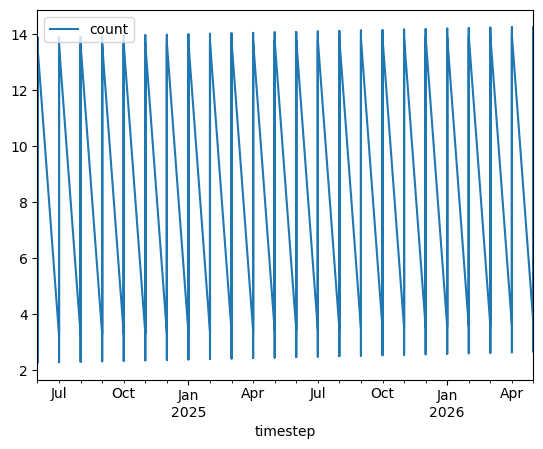

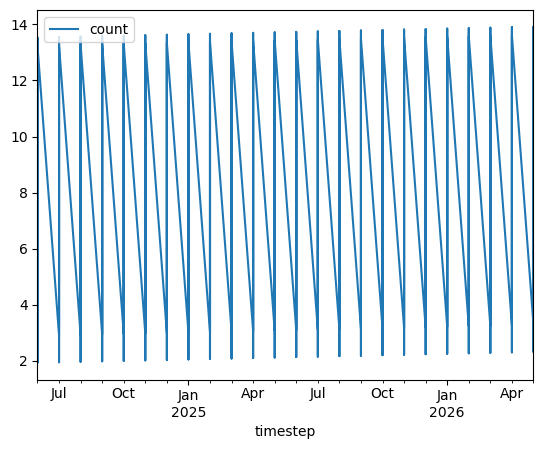

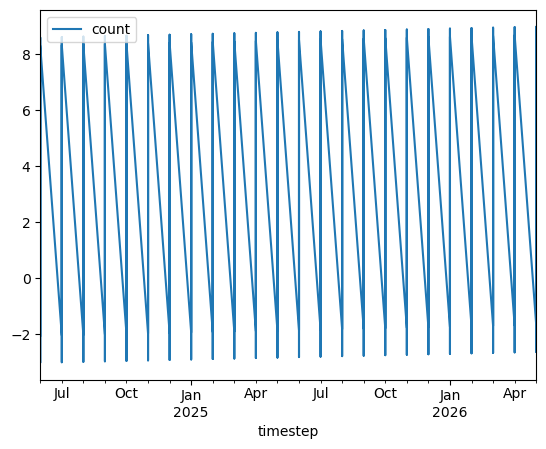

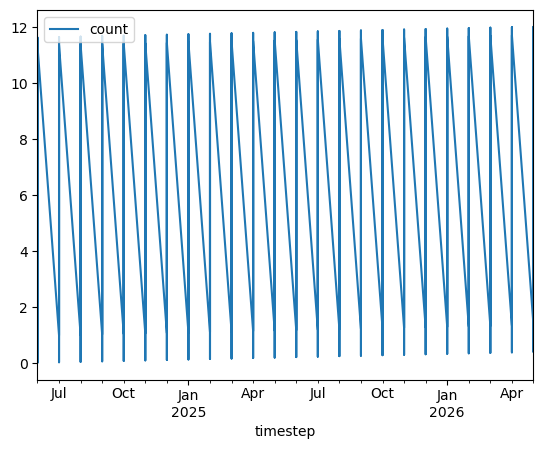

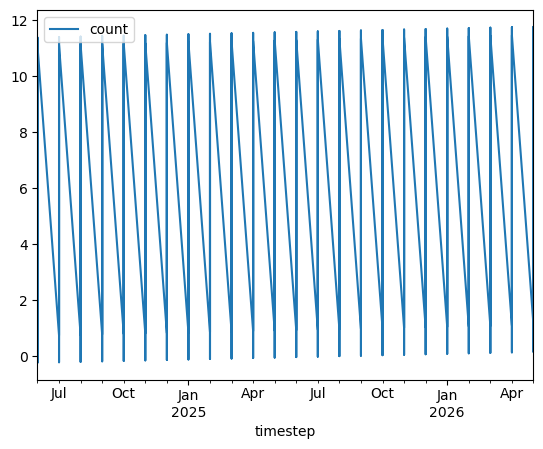

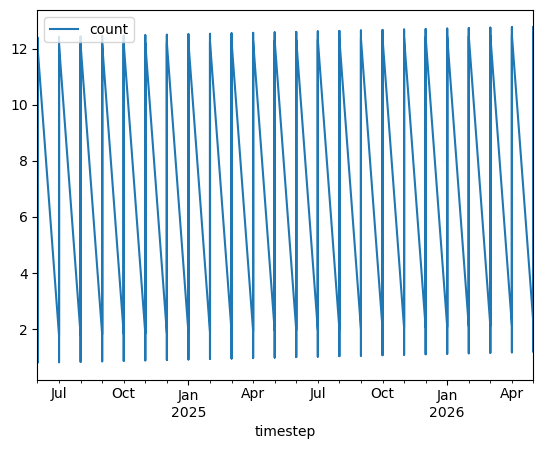

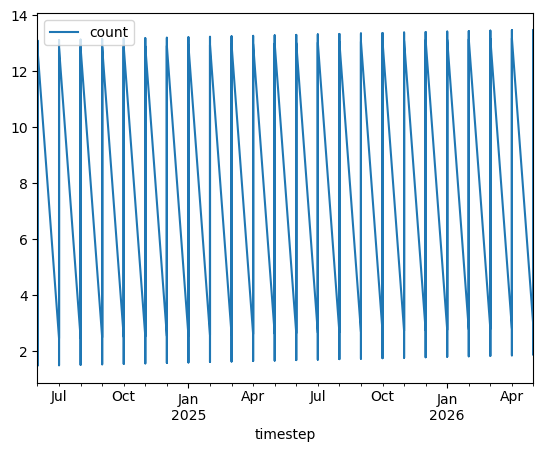

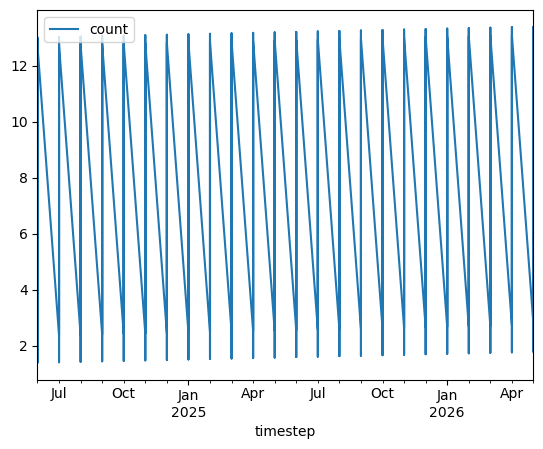

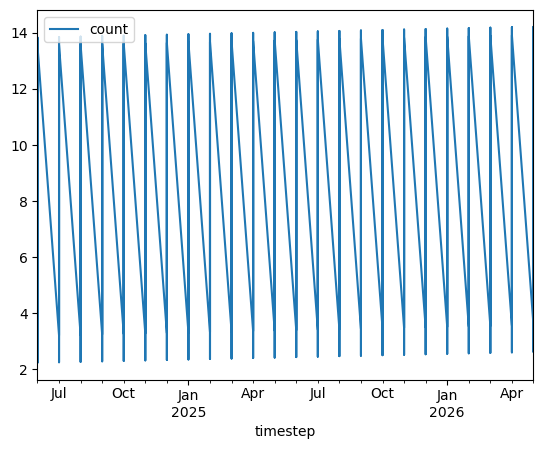

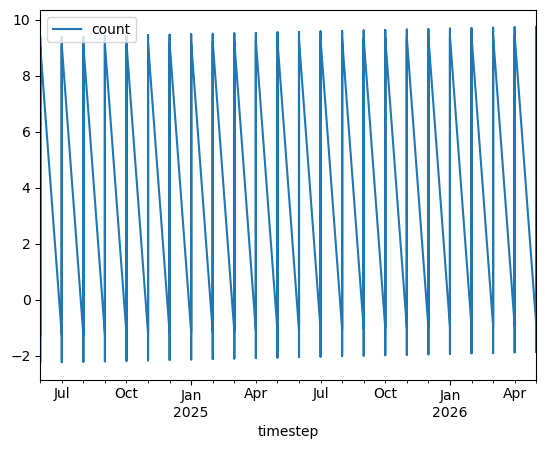

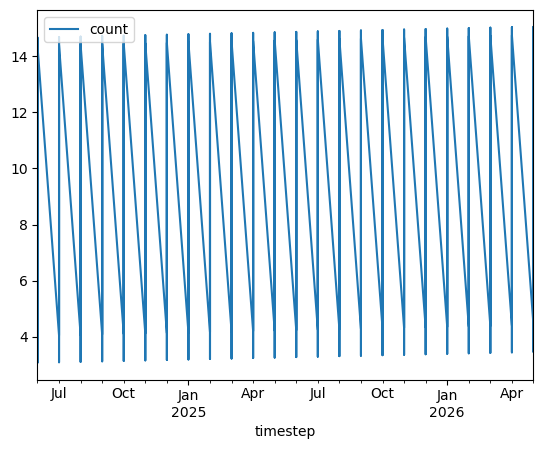

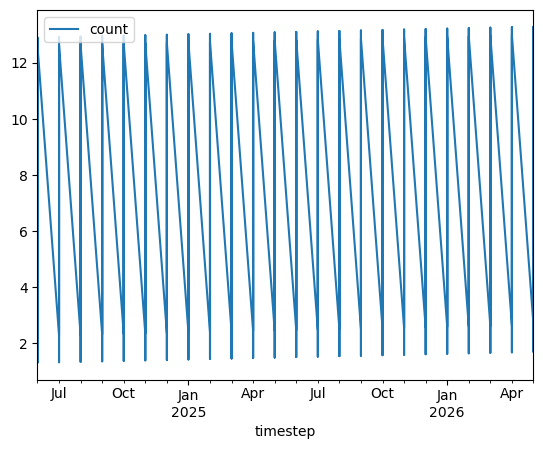

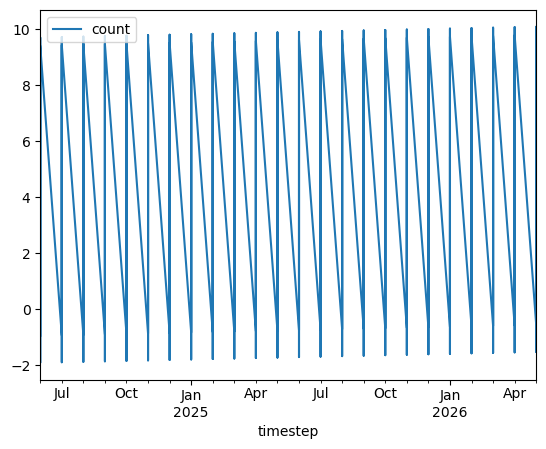

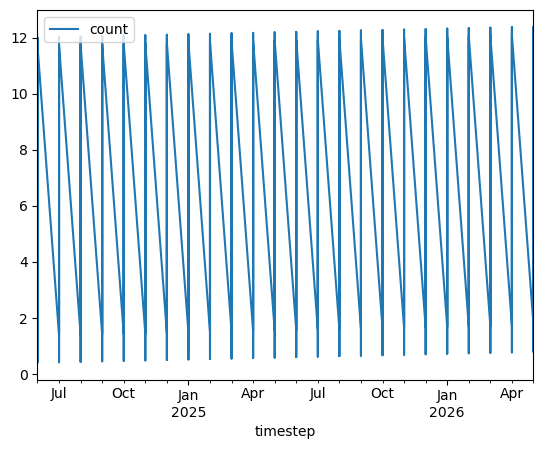

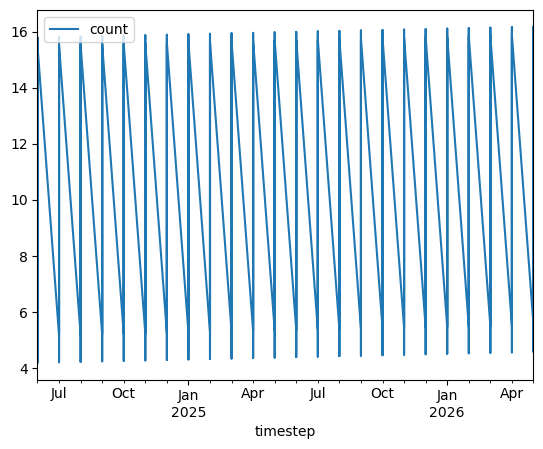

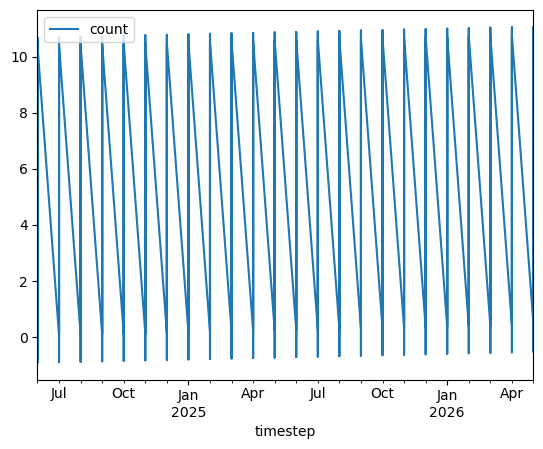

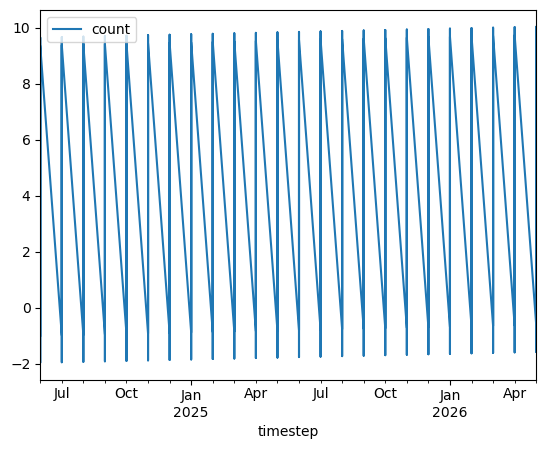

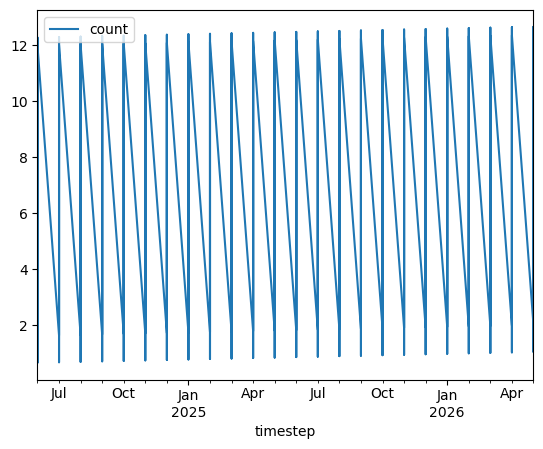

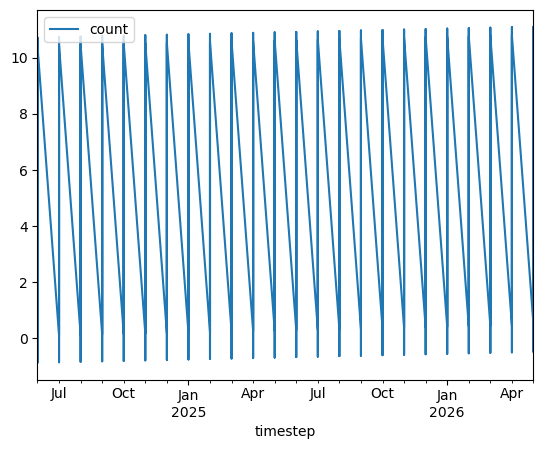

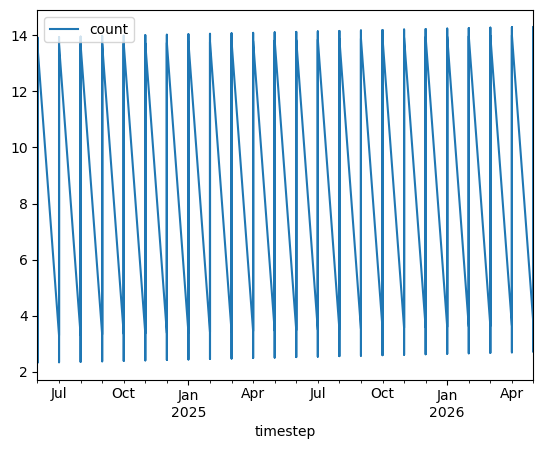

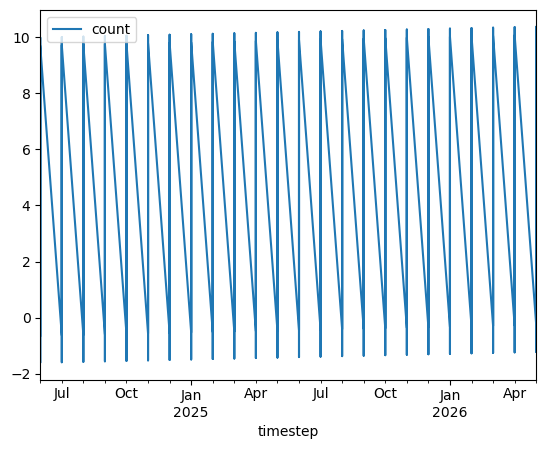

In [16]:
future_predictions_df.to_csv('result_1.csv')
future_predictions_df.groupby('USER_eldership').plot(x='timestep', y='count')